In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import errno
import io

# import matplotlib.pyplot as plt

%matplotlib inline
#plt.style.use('dark_background') 
PATH = 'C:/GitHub/pythonPrograms/computerVision2023/clases/imagenes/'

In [2]:
im = cv.imread(PATH+'cells.png', cv.IMREAD_COLOR)
img = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

In [3]:
def view(img, title = None):
    k = 5
    fig,ax1 = plt.subplots(figsize=(k,k))
    
    if len(img.shape)==2:
        ax1.imshow(img, vmin=0, vmax=255, cmap='gray')
    else:
        ax1.imshow(img) 
    plt.axis('off')
    plt.show()

#### imgpad

In [37]:
def imgpad(img, r):
    if type(r) != int:
        raise TypeError("'r' must be an integer")
        return

    if type(img) != np.ndarray:
        raise TypeError("'img' must be an numpy.ndarray")
        return

    shapeY, shapeX = img.shape
    newShapeY = shapeY + (2*r)
    newShapeX = shapeX + (2*r)

    newImage = np.ndarray((newShapeY,newShapeX), buffer=np.zeros(newShapeX*newShapeY),offset=np.int_().itemsize,dtype=int)

    for i in range(shapeY):
        modifiedRow = np.append(np.zeros(r), img[i])
        modifiedRow = np.append(modifiedRow, np.zeros(r))
        np.copyto(newImage[i+r,:],modifiedRow,casting='unsafe')
        
    return newImage


In [38]:
img.shape

(355, 473)

In [39]:
newImage = imgpad(img,10)
newImage.shape

(375, 493)

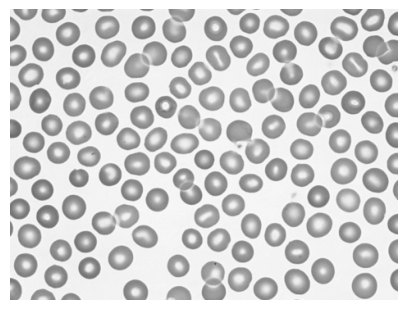

In [40]:
view(img)

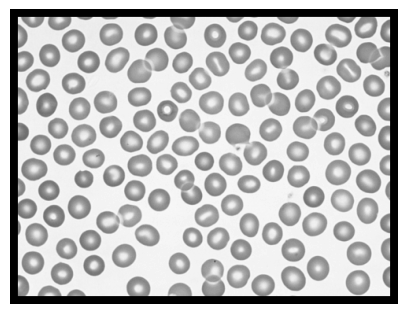

In [41]:
view(newImage)